# CORDEX-CORE urban vs rural vicinity analysis

...

## Load libraries

Here we load the required libraries to execute the notebook. Note that specific code from dedicated scripts (`utils.py`, `urban_areas.py`, ...) is also loaded here.

In [1]:
%load_ext autoreload
%autoreload 2
    
import cartopy.crs as ccrs
import cf_xarray as cfxr
import dask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import xarray as xr

from icecream import ic
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point
from skimage.morphology import dilation, square
from utils import RCM_DICT, MODEL_DICT, YAMLconfig

from urban_areas import (
    load_fix_variables,
    fix_sftuf,
    Urban_vicinity,
    load_variable,
    kelvin2degC,
    load_ucdb_city,
)
from GHCNd_stations import (
    load_ghcnd_stations,
    get_ghcnd_df,
    get_valid_timeseries,
    available_vars,
    get_season,
    inside_city
)
from plot_functions import (
    plot_climatology,
    plot_time_series
)

## Input parameters

These parameters define the behaviour of the notebook, by selecting the `city`, `variable`, and some other items which are mostly self-explanatory. _(Explain here those with are not)_

This cell is tagged `parameters`, in order to be managed externally by the [`papermill` package](https://papermill.readthedocs.io/en/latest).

In [2]:
abbr_city = 'Paris'

variable = 'tasmin'
observations = True
domain = 'EUR-11'
model = 'REMO' # REMO/RegCM
scenario = 'evaluation'
root_esgf = '/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/'
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'
base_output_dir = 'results'

lon_city = 2.35
lat_city = 48.85

urban_th = 0.1
urban_sur_th = 0.1
orog_diff = 100
sftlf_th = 70
scale = 2
lon_lim = 1
lat_lim = 1

Create a directory to save the results for this particular city and model

In [3]:
cities = YAMLconfig('selected_cities.yaml')
city = cities[abbr_city]['name']
model_str = RCM_DICT[domain][model]
output_dir = f"{base_output_dir}/{abbr_city}-{domain}_{model_str}"
os.makedirs(output_dir, exist_ok = True)

In [4]:
domain_resolution = int(domain.split('-')[1])
base_filename = f'{abbr_city}-{domain}_ECMWF-ERAINT_{scenario}_r1i1p1_{model_str}'

## Define urban areas and vicinity

### Load fix variables
Load fix (static) variables, such as urban fraction (sfturf), terrain elevation (orog) or land fraction (sftlf). The urban fraction needs some fixes to align the coordinates with the rest of the variables. These are applied in the `fix_sfturf` function.

In [5]:
ds_sftuf, ds_orog, ds_sftlf = load_fix_variables(domain, model, root_esgf, root_nextcloud)
ds_sftuf = fix_sftuf(domain, model, ds_sftuf, ds_orog, ds_sftlf)

Add parameters to the function

In [6]:
URBAN = Urban_vicinity(
    urban_th, 
    urban_sur_th, 
    orog_diff, 
    sftlf_th,
    scale,
    lon_city,
    lat_city,
    lon_lim,
    lat_lim,
    model_str,
    domain)

Crop area around de city

In [7]:
ds_sftuf = URBAN.crop_area_city(ds_sftuf, domain_resolution)
ds_orog = URBAN.crop_area_city(ds_orog, domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds_sftlf, domain_resolution)

Define masks using the parameters above

In [8]:
sftuf_mask, sftuf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sftuf, 
    ds_orog, 
    ds_sftlf
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [9]:
urmask = URBAN.select_urban_vicinity(
    sftuf_mask, 
    orog_mask,
    sftlf_mask,
    sftuf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

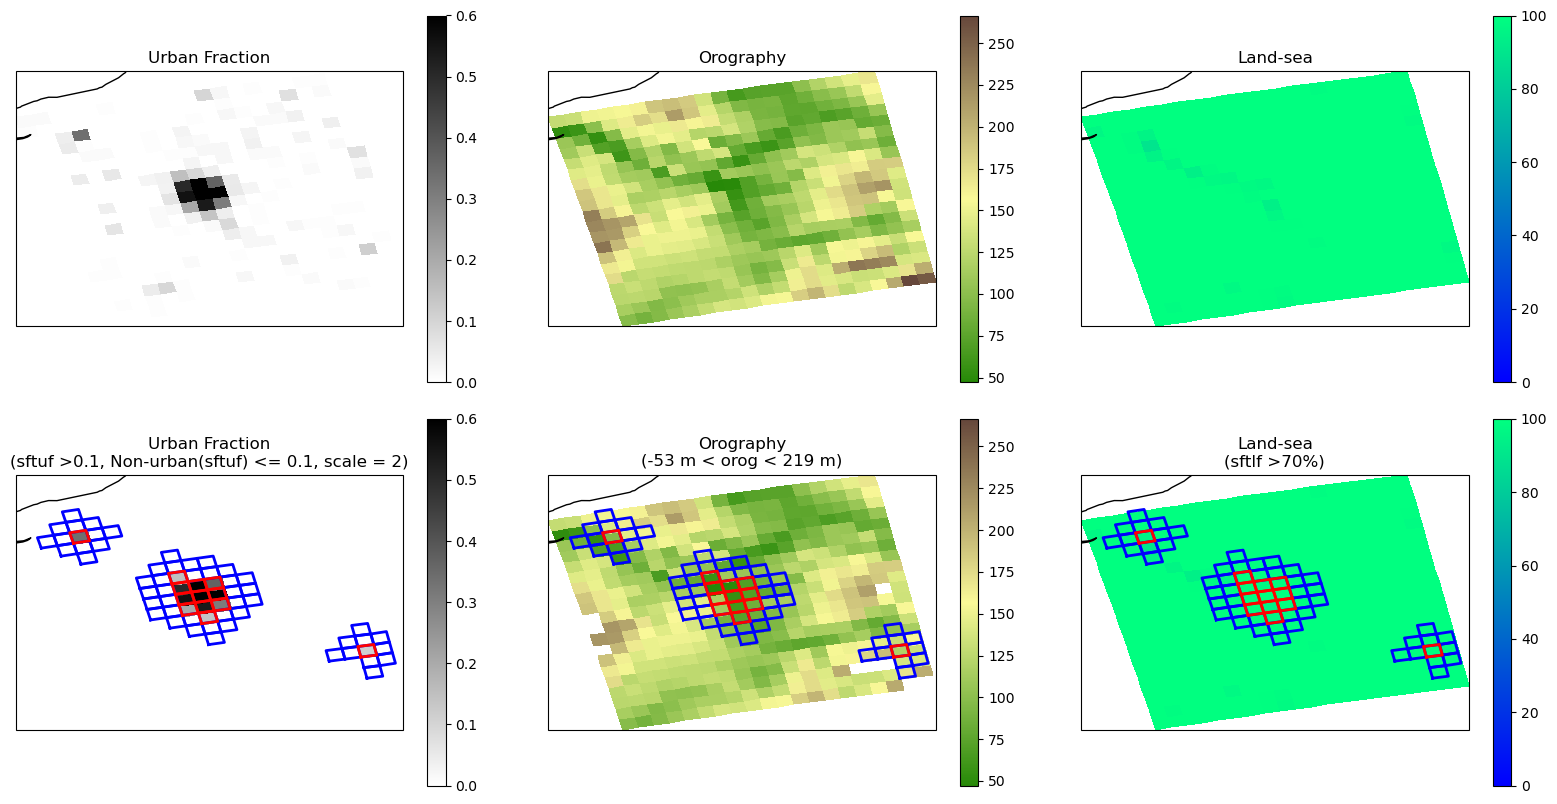

In [10]:
fig = URBAN.plot_fix_variables(ds_sftuf, ds_orog, ds_sftlf,
                                 sftuf_mask, orog_mask, sftlf_mask,
                                 urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [11]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")
ds_sftuf.rename_vars({'sftuf': 'sfturf'}).to_netcdf(f"{output_dir}/sfturf_{base_filename}_fx.nc")

## Calculate urban heat island effect

Remember that we selected above the following parameters:

In [12]:
ic(variable)
ic(city)
ic(observations);

ic| variable: 'tasmin'
ic| city: 'Paris'
ic| observations: True


### Load city shapefile

In [13]:
ucdb_city = load_ucdb_city(root_nextcloud, city)

### Load variable from ESGF DRS

In [14]:
cachefile = f"{output_dir}/{variable}_{base_filename}_day.nc"
if os.path.exists(cachefile):
  print('Reading from cache file.')
  ds_RCM = xr.open_dataset(cachefile)
else:
  ds_RCM = load_variable(root_esgf, root_nextcloud, variable, domain, model, scenario)
  ds_RCM = kelvin2degC(ds_RCM, variable)
  ds_RCM = URBAN.crop_area_city(ds_RCM, domain_resolution)
  ds_RCM.to_netcdf(cachefile)

### Load observations

In [15]:
GHCNd = load_ghcnd_stations(lon_city, lat_city, radious = 0.5)

/lustre/gmeteo/WORK/diezsj/research/cordex-fps-urb-rcc/CORDEX-CORE-WG/uhi/GHCNd_stations.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  rval = ghcnd_stations.assign(dist = ghcnd_stations.distance(Point(lon, lat)))


### Select coincident period between Model and Observations

In [16]:
valid_obs, time_series_obs, ds_RCM_period = get_valid_timeseries(
    city, GHCNd, ds_RCM, variable, idate='1979-01-01', fdate='2014-12-31')

Problem downloading FR000007150
Paris -- ORLY, FR - TMIN has 100.0% valid records in 1979-01-01 to 2014-12-31


/lustre/gmeteo/WORK/diezsj/research/cordex-fps-urb-rcc/CORDEX-CORE-WG/uhi/GHCNd_stations.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{city} -- {stn_data.NAME[0]} - {var} has {100*valid_records:.1f}% valid records in {idate} to {fdate}')


In [17]:
ds_RCM_period_season, time_series_obs_season = get_season(
    ds_RCM_period, time_series_obs, season = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

#### Calculate observations both inside and outside the city

In [18]:
valid_obs = inside_city(valid_obs, ucdb_city)

There are 1 series inside the city and 0 outside
The number of inside/outside observations is 0 therefore valid_obs is empty


/oceano/gmeteo/users/diezsj/miniconda3/envs/cordex-fps-urb-rcc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/lustre/gmeteo/WORK/diezsj/research/cordex-fps-urb-rcc/CORDEX-CORE-WG/uhi/GHCNd_stations.py:153: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  valid_obs.loc[valid_obs['code'].str.contains(obs.code), 'inside_city'] = is_inside.values[0]


### Compute climatology of anomaly with respect to rural vicinity mean

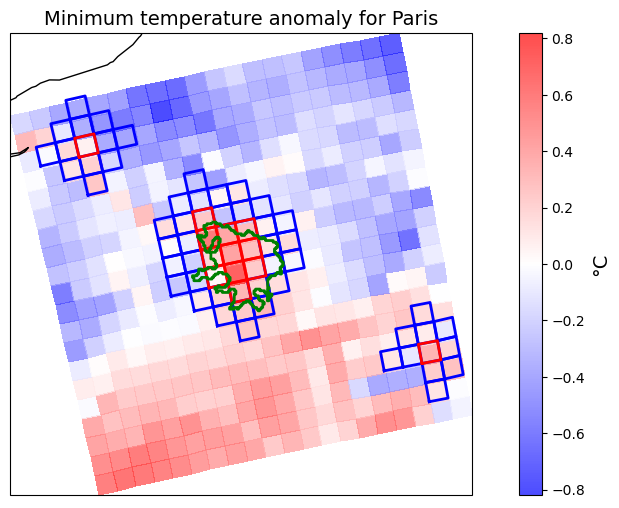

In [19]:
fig = plot_climatology(ds_RCM_period_season, ucdb_city, urmask, variable, 
                       URBAN, valid_obs, time_series_obs_season, city)
fig.savefig(f"{output_dir}/{variable}_{base_filename}_map-anom-wrt-rural.pdf", bbox_inches='tight')

In [20]:
cachefile = f"{output_dir}/{variable}_{base_filename}_acycle-ur.nc"
fig = plot_time_series(ds_RCM, variable, urmask, 
    data_squares = True, city = city, cache = cachefile
)
fig.savefig(cachefile.replace('.nc', '.pdf'), bbox_inches='tight')
plt.close()

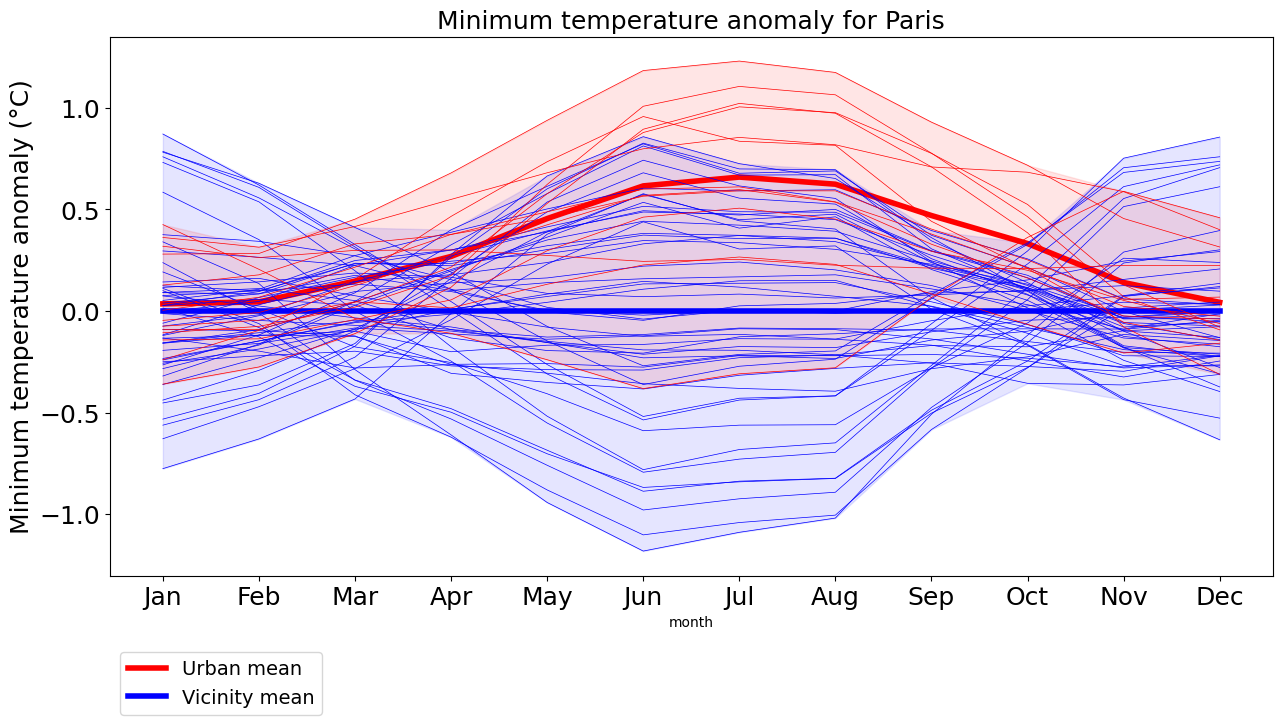

In [21]:
cachefile = f"{output_dir}/{variable}_{base_filename}_acycle-ur-obs.nc"
fig = plot_time_series(ds_RCM, variable, urmask,
    time_series = time_series_obs, valid_stations = valid_obs,
    data_squares = True, ucdb_city = ucdb_city, city = city, cache = cachefile)
fig.savefig(cachefile.replace('.nc', '.pdf'), bbox_inches='tight')